In [1]:
import numpy
import matplotlib.pyplot as plt 
from matplotlib import cm
import pandas
import mglearn

import os
import scipy

import sklearn
import sklearn.ensemble              # import seperatley otherwise sub module won't be imported
import sklearn.neural_network        # import seperatley otherwise sub module won't be imported
from sklearn.cluster import KMeans
import sklearn.feature_selection

import graphviz
import mpl_toolkits.mplot3d as plt3dd

import time



import nltk     # language processing packages for lemmatization
import spacy 

import re

# Data crunching

## Topic modeling and document clustering

One particular technique that is often applied to text data is topic modeling, which is an umbrella term describing the task of assigning each document to one or multiple topics, usually without supervision. A good example for this is news data, which might be categorized into topics like “politics,” “sports,” “finance,” and so on. If each document is assigned a single topic, this is the task of clustering the documents, as discussed in Chapter 3. If each document can have more than one topic, the task relates to the decomposition methods from Chapter 3. Each of the components we learn then corresponds to one topic, and the coefficients of the components in the representation of a document tell us how strongly related that document is to a particular topic. Often, when people talk about topic modeling, they refer to one particular decomposition method called Latent Dirichlet Allocation (often LDA for short)

### Latent dirichlet allocation

Intuitively, the LDA model tries to find groups of words (the topics) that appear together frequently. LDA also requires that each document can be understood as a “mixture” of a subset of the topics. It is important to understand that for the machine learning model a “topic” might not be what we would normally call a topic in everyday speech, but that it resembles more the components extracted by PCA or NMF (which we discussed in Chapter 3), which might or might not have a semantic meaning. Even if there is a semantic meaning for an LDA “topic”, it might not be something we’d usually call a topic. Going back to the example of news articles, we might have a collection of articles about sports, politics, and finance, written by two specific authors. In a politics article, we might expect to see words like “governor,” “vote,” “party,” etc., while in a sports article we might expect words like “team,” “score,” and “season.” Words in each of these groups will likely appear together, while it’s less likely that, for example, “team” and “governor” will appear together. However, these are not the only groups of words we might expect to appear together. The two reporters might prefer different phrases or different choices of words. Maybe one of them likes to use the word “demarcate” and one likes the word “polarize.” Other “topics” would then be “words often used by reporter A” and “words often used by reporter B,” though these are not topics in the usual sense of the word. 

Let’s apply LDA to our movie review dataset to see how it works in practice. For unsupervised text document models, it is often good to remove very common words, as they might otherwise dominate the analysis. We’ll remove words that appear in at least 20 percent of the documents, and we’ll limit the bag-of-words model to the 10,000 words that are most common after removing the top 20 percent:

Movie review data can be downloaded from $\href{https://ai.stanford.edu/\%7Eamaas/data/sentiment/}{link}$

In [5]:
path = r"./Raw Data/aclImdb/";
reviews_train = sklearn.datasets.load_files(path + "train", categories=["pos","neg"]);
reviews_test = sklearn.datasets.load_files(path + "test", categories=["pos","neg"])

text_train, y_train = reviews_train.data, reviews_train.target;
text_test, y_test = reviews_train.data, reviews_train.target;

text_test = [doc.replace(b"<br />", b" ") for doc in text_test];
text_train = [doc.replace(b"<br />",b" ") for doc in text_train];

In [6]:
vect = sklearn.feature_extraction.text.CountVectorizer(max_features=10000, max_df=0.15);

In [7]:
vect.fit(text_train);

In [8]:
X_train = vect.transform(text_train);
X_test = vect.transform(text_test);

In [9]:
lda = sklearn.decomposition.LatentDirichletAllocation(n_components=100, n_jobs=4, learning_method="batch", max_iter=25, random_state=0);

In [10]:
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once

document_topics = lda.fit_transform(X_train)

In [11]:
a_max = document_topics.argmax(axis=1);
bc = numpy.bincount(a_max)
print("Number of docs with primary topic #:\n")
for i, _count in enumerate(bc.ravel()):
    print(f"Topic #{i+1} : {_count}\n")

Number of docs with primary topic #:

Topic #1 : 1240

Topic #2 : 93

Topic #3 : 146

Topic #4 : 76

Topic #5 : 316

Topic #6 : 1058

Topic #7 : 96

Topic #8 : 208

Topic #9 : 75

Topic #10 : 73

Topic #11 : 477

Topic #12 : 73

Topic #13 : 106

Topic #14 : 68

Topic #15 : 87

Topic #16 : 62

Topic #17 : 3019

Topic #18 : 88

Topic #19 : 97

Topic #20 : 87

Topic #21 : 357

Topic #22 : 484

Topic #23 : 64

Topic #24 : 150

Topic #25 : 193

Topic #26 : 1190

Topic #27 : 86

Topic #28 : 75

Topic #29 : 443

Topic #30 : 83

Topic #31 : 57

Topic #32 : 143

Topic #33 : 178

Topic #34 : 106

Topic #35 : 600

Topic #36 : 92

Topic #37 : 721

Topic #38 : 131

Topic #39 : 110

Topic #40 : 89

Topic #41 : 74

Topic #42 : 78

Topic #43 : 222

Topic #44 : 108

Topic #45 : 93

Topic #46 : 97

Topic #47 : 189

Topic #48 : 83

Topic #49 : 123

Topic #50 : 55

Topic #51 : 83

Topic #52 : 153

Topic #53 : 62

Topic #54 : 69

Topic #55 : 146

Topic #56 : 87

Topic #57 : 69

Topic #58 : 133

Topic #59 :

Like the decomposition methods we saw in Chapter 3, LatentDirichletAllocation
has a components_ attribute that stores how important each word is for each topic.
The size of components_ is (n_topics, n_words):

In [22]:
lda.components_.argsort(axis=1)[:,::-1]

array([[2748, 3449,  729, ..., 6278, 6280,    0],
       [ 882, 8473, 9692, ..., 6352, 6354,    0],
       [4090, 4808, 1103, ..., 6380, 6381,    0],
       ...,
       [1432, 7831, 3346, ..., 6439, 6438, 4999],
       [3901,  503, 4976, ..., 6396, 6397,    0],
       [2348, 4462,  859, ..., 6331, 6332,    0]], dtype=int64)

In [27]:
# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
lda_components = lda.components_;
sorting_mask = lda_components.argsort(axis=1)[:,::-1];
feature_names = numpy.array(vect.get_feature_names_out())

In [33]:
topics = numpy.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97]);
sorting_mask = lda.components_.argsort(axis=1)[:,::-1];
feature_names = numpy.array(vect.get_feature_names_out());


mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
sorting=sorting_mask, topics_per_chunk=5, n_words=10)

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
horror        didn          science       gets          beautiful     
creepy        wasn          fiction       car           real          
house         minutes       space         goes          true          
atmosphere    pretty        star          guy           between       
scary         nothing       trek          killed        excellent     
dark          thing         years         girl          moving        
suspense      thought       sci           down          chinese       
thriller      going         fi            around        actors        
fans          boring        captain       police        each          
genre         got           past          home          truly         


topic 36      topic 37      topic 45      topic 51      topic 53      
--------      --------      --------      --------      --------      
perf

In [51]:
# sort by weight of "music" topic 45
document_topics100 = lda.transform(X_train)
topic_x = numpy.argsort(document_topics100[:, 45])[::-1]

In [61]:
for i in topic_x[:10]:
    # pshow first two sentences
    print(b".".join(text_train[i].split(b".")[:2]))
    print("")

b"After losing the Emmy for her performance as Mama Rose in the television version of GYPSY, Bette won an Emmy the following year for BETTE MIDLER: DIVA LAS VEGAS, a live concert special filmed for HBO from Las Vegas. Midler, who has been performing live on stage since the 1970's, proves that she is still one of the most electrifying live performers in the business"

b"After losing the Emmy for her performance as Mama Rose in the television version of GYPSY, Bette won an Emmy the following year for BETTE MIDLER: DIVA LAS VEGAS, a live concert special filmed for HBO from Las Vegas. Midler, who has been performing live on stage since the 1970's, proves that she is still one of the most electrifying live performers in the business"

b"Surviving Christmas (2004) Ben Affleck, James Gandolfini, Christina Applegate, Catherine O' Hara, Josh Zuckerman, Bill Macy, Jennifer Morrison, Udo Kier, D: Mike Mitchell. Dumped by his girlfriend, a hotshot yuppie doesn't want to be left alone on Christmas 

As we can see, this topic covers a wide variety of music-centered reviews, from musicals,
to biographical movies, to some hard-to-specify genre in the last review. Another
interesting way to inspect the topics is to see how much weight each topic gets overall,
by summing the document_topics over all reviews. We name each topic by the
two most common words.

In [74]:
sorting = numpy.argsort(lda.components_, axis=1)
feature_names = vect.get_feature_names_out()
topic_names = ["{:>2} ".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:,:2]])]

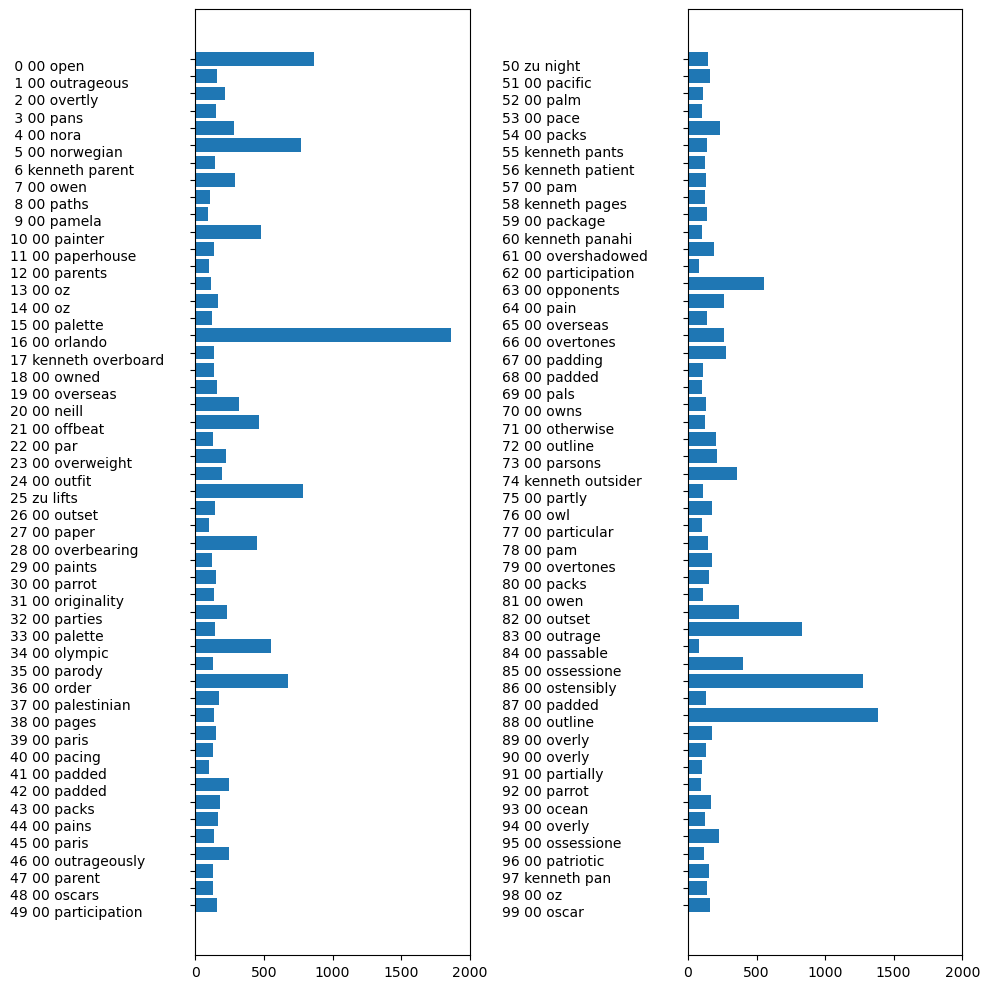

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(10,10));

for col in [0, 1]:
    start = col * 50;
    end = (col + 1) * 50;
    
    ax[col].barh(numpy.arange(50), numpy.sum(document_topics100, axis=0)[start:end]);
    ax[col].set_yticks(numpy.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

The most important topics are 97, which seems to consist mostly of stopwords, possibly
with a slight negative direction; topic 16, which is clearly about bad reviews; followed
by some genre-specific topics and 36 and 37, both of which seem to contain
laudatory words.


It seems like LDA mostly discovered two kind of topics, genre-specific and ratingspecific,
in addition to several more unspecific topics. This is an interesting discovery,
as most reviews are made up of some movie-specific comments and some comments
that justify or emphasize the rating.


Topic models like LDA are interesting methods to understand large text corpora in
the absence of labels—or, as here, even if labels are available. The LDA algorithm is
randomized, though, and changing the random_state parameter can lead to quite different outcomes. While identifying topics can be helpful, any conclusions youdraw from an unsupervised model should be taken with a grain of salt, and we recommend
verifying your intuition by looking at the documents in a specific topic. The
topics produced by the LDA.transform method can also sometimes be used as a compact
representation for supervised learning. This is particularly helpful when few
training examples are available.

## Summary Outlook

In this chapter we talked about the basics of processing text, also known as natural
language processing (NLP), with an example application classifying movie reviews.
The tools discussed here should serve as a great starting point when trying to process
text data. In particular for text classification tasks such as spam and fraud detection
or sentiment analysis, bag-of-words representations provide a simple and powerful
solution. As is often the case in machine learning, the representation of the data is key
in NLP applications, and inspecting the tokens and n-grams that are extracted can
give powerful insights into the modeling process. In text-processing applications, it is
often possible to introspect models in a meaningful way, as we saw in this chapter, for
both supervised and unsupervised tasks. You should take full advantage of this ability
when using NLP-based methods in practice.


Natural language and text processing is a large research field, and discussing the
details of advanced methods is far beyond the scope of this book. If you want to learn
more, we recommend the O’Reilly book $\href{http://shop.oreilly.com/product/9780596516499.do}{Natural \ Language \ Processing \ with \ Python}$ by
Steven Bird, Ewan Klein, and Edward Loper, which provides an overview of NLP
together with an introduction to the nltk Python package for NLP. Another great and
more conceptual book is the standard reference $\href{https://nlp.stanford.edu/IR-book/}{Introduction \ to \ Information \ Retrieval}$
by Christopher Manning, Prabhakar Raghavan, and Hinrich Schütze, which describes
fundamental algorithms in information retrieval, NLP, and machine learning. Both
books have online versions that can be accessed free of charge. As we discussed earlier,
the classes CountVectorizer and TfidfVectorizer only implement relatively
simple text-processing methods. For more advanced text-processing methods, we
recommend the Python packages spacy (a relatively new but very efficient and welldesigned
package), nltk (a very well-established and complete but somewhat dated
library), and gensim (an NLP package with an emphasis on topic modeling).



There have been several very exciting new developments in text processing in recent
years, which are outside of the scope of this book and relate to neural networks. The
first is the use of continuous vector representations, also known as word vectors or
distributed word representations, as implemented in the word2vec library. The original
paper “$\href{https://papers.nips.cc/paper_files/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html}{Distributed \ Representations \ of \ Words \ and \ Phrases \ and \ Their \ Compositionality}$” by Thomas Mikolov et al. is a great introduction to the subject. Both spacy and gensim provide functionality for the techniques discussed in this paper and its follow-ups.


Another direction in NLP that has picked up momentum in recent years is the use of
recurrent neural networks (RNNs) for text processing. RNNs are a particularly powerful
type of neural network that can produce output that is again text, in contrast to
classification models that can only assign class labels. The ability to produce text as
output makes RNNs well suited for automatic translation and summarization. An
introduction to the topic can be found in the relatively technical paper "$\href{papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf}{Sequence \ to \ Sequence \ Learning \ with \ Neural \ Networks}$” by Ilya Suskever, Oriol Vinyals, and Quoc
Le. A more practical tutorial using the tensorflow framework can be found on the
TensorFlow website.

A more practical tutorial using the tensorflow framework can be found on the
$\href{https://www.tensorflow.org/}{TensorFlow \ website}$.